In [14]:
import torch
import torch.nn as nn
import logging
import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import model 
import data_processing  
import data_preprocessing  


process_imgs = data_processing.process_imgs
process_and_save_silhouette = data_preprocessing.process_and_save_silhouette
get_model = model.get_model
RusticModel = model.RusticModel
ViTModel = model.ViTModel

In [15]:

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename="./logs/data_validation.log",  # Nombre del archivo de log
    filemode="a",  # Modo de apertura en append para no sobrescribir
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [16]:
# Configuración del dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Usando dispositivo: {device}")


In [17]:
def load_and_process_data(data_directory):
    X_train, X_val, y_train, y_val, label_mapping = process_imgs(data_directory, dir)
    return X_train, X_val, y_train, y_val, label_mapping

In [18]:
def convert_to_tensors(X, y):
    X = torch.tensor(X, dtype=torch.float32)
    if X.dim() == 3:
        X = X.unsqueeze(1)
    else:
        X = X.permute(0, 3, 1, 2)
    y = torch.tensor(y, dtype=torch.long)
    return X, y


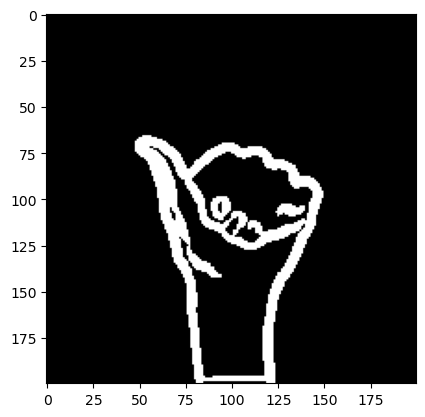

In [19]:
# Define la ruta del directorio de datos
data_directory = "/home/rosewt/Documentos/codigos2024/SordoMudos/datasets/Static-Hand-Gestures-of-the-Peruvian-Sign-Language-Alphabet"

# Cargar y procesar los datos
X_train, X_val, y_train, y_val, label_mapping = load_and_process_data(data_directory)


plt.imshow(X_train[0], cmap="gray")

# Convertir los datos de validación a tensores
X_val, y_val = convert_to_tensors(X_val, y_val)

# Información sobre el conjunto de validación
logging.info(f"Tamaño del conjunto de validación: {len(X_val)}")


In [20]:
# Seleccionar el modelo y número de clases
num_classes = len(label_mapping)
model = RusticModel(num_classes).to(device)
# Alternativa: model = ViTModel(num_classes).to(device)

# Cargar los pesos del modelo entrenado
model_path = "rustic.pth"  # Ruta de tu modelo entrenado
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
logging.info(f"Modelo cargado exitosamente desde {model_path}")




/tmp/ipykernel_15896/3820318020.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [21]:
# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Evaluar el modelo
val_loss = 0
val_correct = 0
with torch.no_grad():
    for i in range(len(X_val)):
        images = X_val[i].unsqueeze(0).to(device)  # Agregar dimensión batch
        labels = y_val[i].unsqueeze(0).to(device)

        # Redimensionar las imágenes a 224x224
        images = nn.functional.interpolate(images, size=(224, 224))

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Acumulación de la pérdida y precisión
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()

# Calcular la pérdida y precisión de validación
val_loss /= len(X_val)
val_accuracy = val_correct / len(X_val)
logging.info(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [23]:
# Obtener todas las predicciones y etiquetas verdaderas para el conjunto de validación
def get_predictions_and_labels(model, X_val, y_val):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for i in range(len(X_val)):
            images = X_val[i].unsqueeze(0).to(device)  # Añadir dimensión batch
            labels = y_val[i].unsqueeze(0).to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Guardar predicciones y etiquetas
            all_preds.append(predicted.item())
            all_labels.append(labels.item())
    
    return np.array(all_labels), np.array(all_preds)


In [24]:
# Obtener las predicciones y etiquetas verdaderas
y_true, y_pred = get_predictions_and_labels(model, X_val, y_val)

X_val

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x36864 and 50176x256)

In [ ]:


# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_mapping.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Matriz de Confusión")
plt.show()


## Pruebas unitarias

In [ ]:
import import_ipynb

from PIL import Image
from torchvision import transforms
import data_preprocessing  
import cv2

binarize_with_canny = data_preprocessing.binarize_with_canny


In [ ]:
def preprocess_single_image(model, val, predict):

    model.eval()
    with torch.no_grad():    
        image = val.unsqueeze(0).to(device)  # Añadir dimensión batch
        labels = predict.unsqueeze(0).to(device)
        # Forward pass
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        
        # Guardar predicciones y etiquetas
        v = labels.item()
        p = predicted.item()

    return v, p


In [ ]:

def preprocess_single_image(image_path):
    """
    Carga y preprocesa una sola imagen para pasarla por el modelo.
    """
    # Definir las transformaciones necesarias
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
        transforms.Resize((224, 224)),               # Redimensionar a 224x224
        transforms.ToTensor(),                       # Convertir a tensor
        transforms.Normalize((0.5,), (0.5,))         # Normalizar (ajusta según el entrenamiento)
    ])

    # Cargar la imagen
    image = cv2.imread(image_path)

    #image = binarize_with_canny(image)

    image = Image.fromarray(image)

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    
    # Aplicar transformaciones
    image = transform(image)

    plt.subplot(1, 2, 2)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.show()
    
    # Agregar una dimensión para el batch
    image = image.unsqueeze(0)
    
    return image


In [ ]:
def predict_single_image(model, image_tensor, label_mapping):
    """
    Realiza una predicción para una sola imagen.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        # Pasar la imagen por el modelo
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        
        # Obtener la predicción
        _, predicted = torch.max(output, 1)

        predicted_label = predicted.item()
        
        # Mapear el índice a la etiqueta correspondiente
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]
        
    return label_name


In [ ]:
# Ruta de la imagen de prueba

test_image_path = './augmented_images/a/a (3)_original.jpg'
test_image_path = './augmented_images/s/s (3)_original.jpg'



import data_processing
process_imgs = data_processing.process_imgs
preprocess = data_processing.preprocess

test_path = "/home/rosewt/Documentos/codigos2024/SordoMudos/src/notebooks/test"


imgs = preprocess(test_path, output_dir='test_augmented')

print(type(imgs[0]))
print(len(imgs[0]))

plt.imshow(imgs[0][4], cmap="gray")
plt.show()

label_to_index = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}


y_val = ['a'] * len(imgs)


imgs_resized = imgs

#print(len(imgs_resized))

#X_val = torch.tensor(imgs_resized, dtype=torch.float32).unsqueeze(1)  # Añade dimensión de canal
#y_val = torch.tensor(y_val, dtype=torch.long)

<class 'list'>
2


IndexError: list index out of range

In [ ]:


# Convertir los datos de validación a tensores
X_val, y_val = convert_to_tensors(imgs, y_val)


# Seleccionar el modelo y número de clases
num_classes = len(label_mapping)
model = RusticModel(num_classes).to(device)
# Alternativa: model = ViTModel(num_classes).to(device)

# Cargar los pesos del modelo entrenado
model_path = "rustic.pth"  # Ruta de tu modelo entrenado
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
logging.info(f"Modelo cargado exitosamente desde {model_path}")


/tmp/ipykernel_31659/438072132.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X, dtype=torch.float32)


ValueError: expected sequence of length 224 at dim 2 (got 1)

In [ ]:
# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Evaluar el modelo
val_loss = 0
val_correct = 0
with torch.no_grad():
    for i in range(len(X_val)):
        images = X_val[i].unsqueeze(0).to(device)  # Agregar dimensión batch
        labels = y_val[i].unsqueeze(0).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Acumulación de la pérdida y precisión
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()

# Calcular la pérdida y precisión de validación
val_loss /= len(X_val)
val_accuracy = val_correct / len(X_val)
logging.info(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
